In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np


from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

In [ ]:
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
!pip install -q xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/AB_Test_sem8.xlsx')

data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [ ]:
data.info()#строк 10000, типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
data.shape # строки, столбцы

(10000, 3)

In [ ]:
data = data.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [ ]:
data.shape

(7865, 3)

In [ ]:
data.VARIANT_NAME.value_counts()

variant    3934
control    3931
Name: VARIANT_NAME, dtype: int64

In [ ]:
data.isna().sum() #кол-во нулевых значений

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [ ]:
data.USER_ID.nunique()

6324

In [ ]:
data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts() #посдсчет кол-ва строк где 1ому юзер id соответсвует несколько variant_name

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [ ]:
unique_ids = \ # оставляем только уникальных юзер
(data
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 #.['VARIANT_NAME'].value_counts()
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )
len (unique_ids)

4783

In [ ]:
new_data = data[data['REVENUE']>0] #строки с выручкой больше нуля
new_data


,USER_ID,VARIANT_NAME,REVENUE
37,56,variant,2.99
89,124,control,1.25
125,169,control,4.33
211,282,control,18.56
314,403,variant,1.99
...,...,...,...
7617,9669,variant,1.99
7693,9766,control,3.79
7807,9928,variant,1.25
7822,9942,variant,3.25


In [ ]:
data_new = data[data.USER_ID.isin(unique_ids)].copy(deep=True)
data_new = data[data.USER_ID.isin(unique_ids)].copy()
data_new.shape

(4783, 3)

In [ ]:
data_new.describe()  #числовые статистики

,USER_ID,REVENUE
count,"4,783.00","4,783.00"
mean,"4,994.40",0.14
std,"2,898.62",3.01
min,2.00,0.00
25%,"2,476.00",0.00
50%,"4,975.00",0.00
75%,"7,515.00",0.00
max,"9,998.00",196.01


In [ ]:
data_new[data_new['VARIANT_NAME'] == 'variant']

,USER_ID,VARIANT_NAME,REVENUE
3,4,variant,0.00
4,5,variant,0.00
5,6,variant,0.00
6,9,variant,0.00
12,15,variant,0.00
...,...,...,...
7844,9975,variant,0.00
7853,9983,variant,0.00
7854,9986,variant,0.00
7856,9990,variant,0.00


Сплитование равномерное

In [ ]:
new_data[data['VARIANT_NAME']=='variant'].describe() #рассмотрим отдельно выручку теста и контроля

,USER_ID,REVENUE
count,71.00,71.00
mean,"5,270.27",4.95
std,"3,123.03",9.97
min,56.00,0.02
25%,"2,648.00",1.24
50%,"5,597.00",2.24
75%,"8,012.50",3.98
max,"9,996.00",58.63


In [ ]:
new_data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,80.00,80.00
mean,"4,461.95",8.04
std,"2,826.39",22.50
min,124.00,0.02
25%,"2,037.50",1.52
50%,"4,327.00",2.96
75%,"6,636.75",6.66
max,"9,766.00",196.01


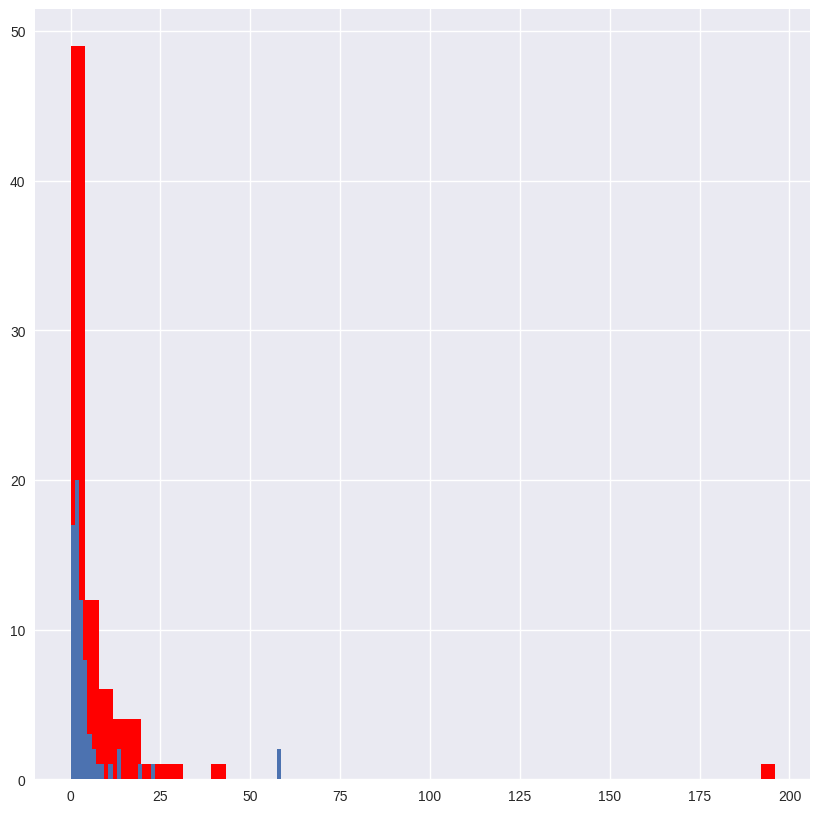

In [ ]:
plt.figure(figsize=(10, 10)) #Метрика визиты на юзера
control_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [ ]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)# Т-тест, дисперсии не равны

Ttest_indResult(statistic=1.1105825827497187, pvalue=0.26913377074080375)

p value > 0.05
Значимых изменений нет

In [ ]:
# Функция бутстрепа
from scipy.stats import norm

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}


100%|██████████| 10000/10000 [00:03<00:00, 2879.78it/s]


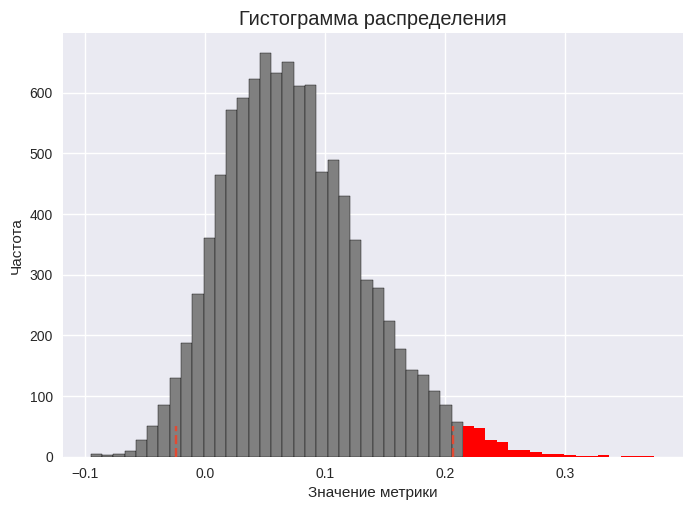

p_value 0.20551889314344796


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format
# если 0 включен в доверительный интервал между группами нет разницы
# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(data['REVENUE'][data['VARIANT_NAME']=='control'],
                            data['REVENUE'][data['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

p_value 0.20490703759651707
p_value > 0.05
Нет стат. значимости.

Данный результат означает, что значение p-уровня значимости равно 0.20490703759651707, что больше уровня значимости 0.05. Это говорит нам о том, что нет статистически достоверных различий между группами данных, и мы не можем отвергнуть нулевую гипотезу.